<a href="https://colab.research.google.com/github/harjeet88/stock-prediction/blob/main/grok/stock_trader_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6705f9023a9b5c799cc6c66be8aa5abce6389bb9864d6be354ff53d8bc4bb351
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator
from scipy.signal import find_peaks
import datetime


In [60]:
# Define the stock ticker and date range
ticker = "CAMS.NS"  # Change to any stock ticker
start_date = "2023-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

# Fetch stock data
stock = yf.Ticker(ticker)
df = stock.history(start=start_date, end=end_date)

In [61]:
# Fundamental Analysis
info = stock.info
fundamentals = {
    "Company": info.get("longName", "N/A"),
    "Sector": info.get("sector", "N/A"),
    "P/E Ratio": info.get("trailingPE", "N/A"),
    "EPS": info.get("trailingEps", "N/A"),
    "Dividend Yield": info.get("dividendYield", "N/A"),
    "Market Cap": info.get("marketCap", "N/A"),
    "52 Week High": info.get("fiftyTwoWeekHigh", "N/A"),
    "52 Week Low": info.get("fiftyTwoWeekLow", "N/A")
}

print("\nFundamental Analysis for", ticker)
for key, value in fundamentals.items():
    print(f"{key}: {value}")


Fundamental Analysis for CAMS.NS
Company: Computer Age Management Services Limited
Sector: Technology
P/E Ratio: 44.326595
EPS: 95.04
Dividend Yield: 1.47
Market Cap: 208237854720
52 Week High: 5367.5
52 Week Low: 3031.05


In [62]:
# Technical Indicators
# MACD
macd = MACD(df["Close"], window_slow=26, window_fast=12, window_sign=9)
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()
df["MACD_Hist"] = macd.macd_diff()

In [63]:
# RSI
rsi = RSIIndicator(df["Close"], window=14)
df["RSI"] = rsi.rsi()

In [64]:
# Supertrend
def supertrend(df, period=10, multiplier=3):
    hl2 = (df["High"] + df["Low"]) / 2
    atr = (df["High"] - df["Low"]).rolling(window=period).mean()
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)
    supertrend = pd.Series(index=df.index, dtype=float)
    trend = pd.Series(index=df.index, dtype=bool)

    for i in range(1, len(df)):
        if df["Close"].iloc[i-1] > supertrend.iloc[i-1]:
            supertrend.iloc[i] = lowerband.iloc[i]
            trend.iloc[i] = True  # Uptrend
        else:
            supertrend.iloc[i] = upperband.iloc[i]
            trend.iloc[i] = False  # Downtrend
        if i == 1:
            supertrend.iloc[i] = lowerband.iloc[i]
            trend.iloc[i] = True

    return supertrend, trend

df["Supertrend"], df["Trend"] = supertrend(df)

In [65]:
# Enhanced Elliott Wave Detection
def calculate_fibonacci_levels(wave_start, wave_end):
    diff = wave_end - wave_start
    fib_382 = wave_end - 0.382 * diff
    fib_50 = wave_end - 0.5 * diff
    fib_618 = wave_end - 0.618 * diff
    return fib_382, fib_50, fib_618

In [66]:
def detect_elliott_wave(df, prominence=0.05):
    # Smooth data with 20-period SMA to reduce noise
    df["SMA20"] = df["Close"].rolling(window=20).mean()
    prices = df["SMA20"].fillna(df["Close"]).values
    peaks, _ = find_peaks(prices, prominence=prominence * prices.mean())
    troughs, _ = find_peaks(-prices, prominence=prominence * prices.mean())

    # Initialize wave points
    wave_points = []
    wave_labels = []
    current_wave = 0
    i = 0

    while i < len(peaks) and i < len(troughs) and current_wave < 5:
        # Wave 1: Up from trough to peak
        if troughs[i] < peaks[i]:
            wave_points.append((troughs[i], df["Close"].iloc[troughs[i]], "1"))
            wave_points.append((peaks[i], df["Close"].iloc[peaks[i]], "2"))
            wave_1_start = df["Close"].iloc[troughs[i]]
            wave_1_end = df["Close"].iloc[peaks[i]]
            current_wave = 2
            i += 1
        else:
            i += 1
            continue

        # Wave 2: Retracement (check Fibonacci levels)
        if i < len(troughs):
            wave_2_end = df["Close"].iloc[troughs[i]]
            fib_382, fib_50, fib_618 = calculate_fibonacci_levels(wave_1_start, wave_1_end)
            if fib_618 <= wave_2_end <= fib_382 and wave_2_end > wave_1_start:
                wave_points.append((troughs[i], wave_2_end, "3"))
                current_wave = 3
                i += 1

        # Wave 3: Up, must be longer than Wave 1
        if i < len(peaks):
            wave_3_end = df["Close"].iloc[peaks[i]]
            if wave_3_end > wave_1_end and (wave_3_end - wave_2_end) > (wave_1_end - wave_1_start):
                wave_points.append((peaks[i], wave_3_end, "4"))
                current_wave = 4
                i += 1

        # Wave 4: Retracement, no overlap with Wave 1
        if i < len(troughs):
            wave_4_end = df["Close"].iloc[troughs[i]]
            fib_382, fib_50, fib_618 = calculate_fibonacci_levels(wave_2_end, wave_3_end)
            if fib_618 <= wave_4_end <= fib_382 and wave_4_end > wave_1_end:
                wave_points.append((troughs[i], wave_4_end, "5"))
                current_wave = 5
                i += 1

        # Wave 5: Final impulse
        if i < len(peaks):
            wave_5_end = df["Close"].iloc[peaks[i]]
            if wave_5_end > wave_3_end:
                wave_points.append((peaks[i], wave_5_end, "A"))
                current_wave = 6  # Start of correction
                i += 1

    # Determine current wave state
    current_state = "Unknown"
    if wave_points:
        last_label = wave_points[-1][2]
        if last_label == "A":
            current_state = "In Corrective Wave A"
        elif last_label == "5":
            current_state = "In Wave 5 (End of Impulse)"
        elif last_label == "4":
            current_state = "In Wave 4 (Correction)"
        elif last_label == "3":
            current_state = "In Wave 3 (Strong Impulse)"
        elif last_label == "2":
            current_state = "In Wave 2 (Correction)"
        elif last_label == "1":
            current_state = "In Wave 1 (Initial Impulse)"

    return wave_points, current_state

In [67]:
wave_points, current_state = detect_elliott_wave(df)

# Generate Trade Signals
def generate_trade_signals(df, wave_points):
    buy_signals = []
    sell_signals = []
    df["Signal"] = 0  # 0: No signal, 1: Buy, -1: Sell

    for i in range(1, len(df)):
        # Buy: MACD crossover, RSI < 40, price above Supertrend, near Wave 1 or 3 start
        wave_labels = [wp[2] for wp in wave_points]
        wave_indices = [wp[0] for wp in wave_points]
        if (df["MACD"].iloc[i] > df["MACD_Signal"].iloc[i] and
            df["MACD"].iloc[i-1] <= df["MACD_Signal"].iloc[i-1] and
            df["RSI"].iloc[i] < 40 and
            df["Trend"].iloc[i] and
            any(abs(i - idx) <= 5 and label in ["1", "3"] for idx, label in zip(wave_indices, wave_labels))):
            df["Signal"].iloc[i] = 1
            buy_signals.append(i)
        # Sell: MACD crossunder, RSI > 60, price below Supertrend, near Wave 5 or A
        elif (df["MACD"].iloc[i] < df["MACD_Signal"].iloc[i] and
              df["MACD"].iloc[i-1] >= df["MACD_Signal"].iloc[i-1] and
              df["RSI"].iloc[i] > 60 and
              not df["Trend"].iloc[i] and
              any(abs(i - idx) <= 5 and label in ["5", "A"] for idx, label in zip(wave_indices, wave_labels))):
            df["Signal"].iloc[i] = -1
            sell_signals.append(i)

    return buy_signals, sell_signals

buy_signals, sell_signals = generate_trade_signals(df, wave_points)


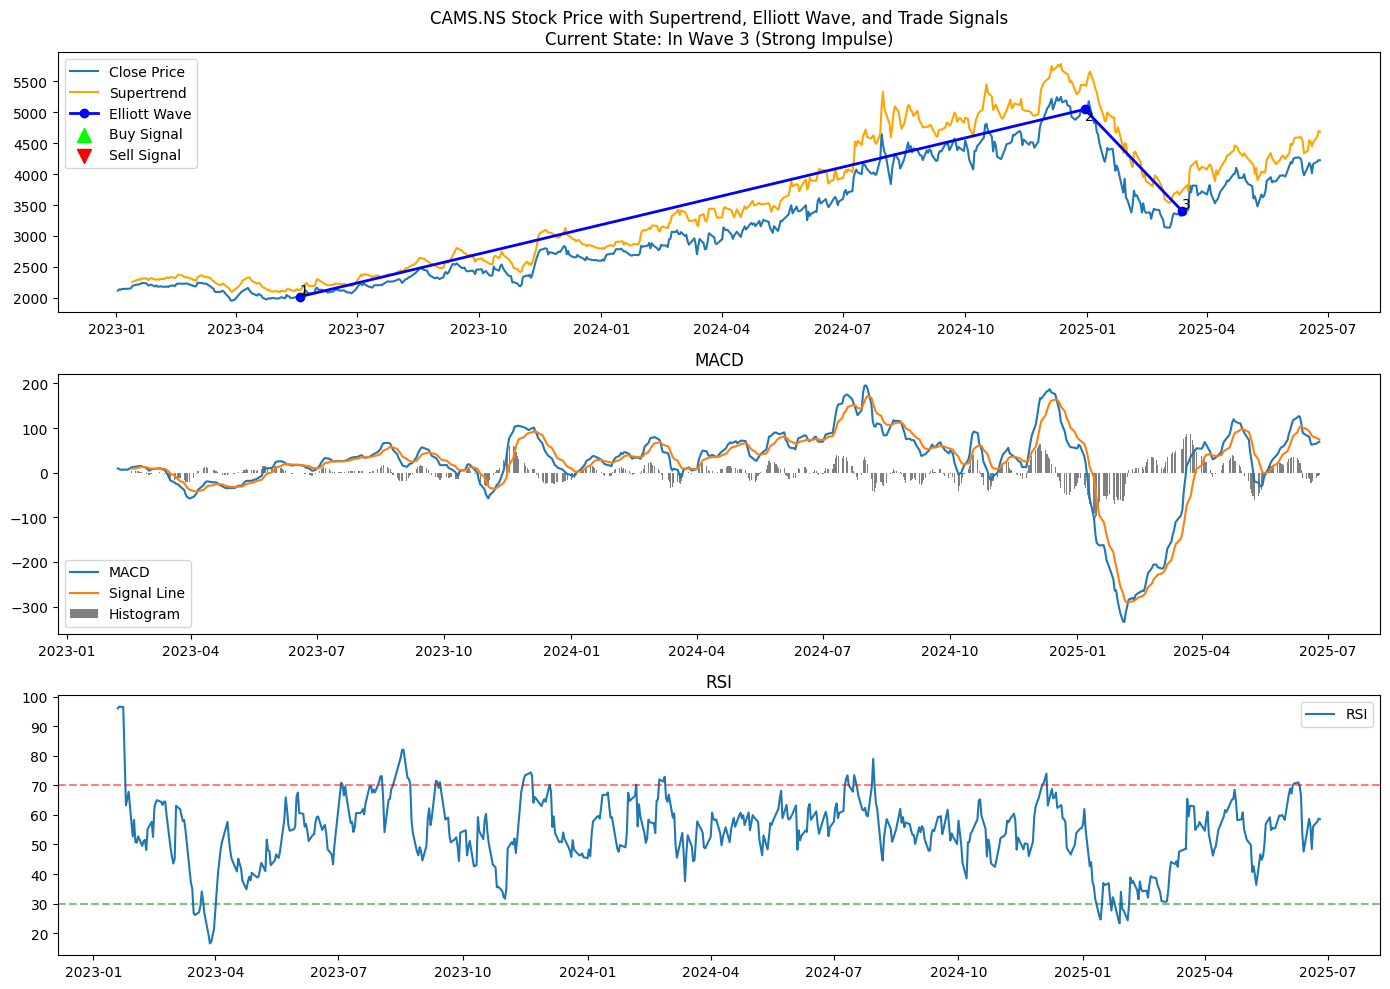

In [68]:
# Plotting
plt.figure(figsize=(14, 10))

# Price and Supertrend with Elliott Waves
plt.subplot(3, 1, 1)
plt.plot(df.index, df["Close"], label="Close Price")
plt.plot(df.index, df["Supertrend"], label="Supertrend", color="orange")
# Plot Elliott Wave points and lines
if wave_points:
    wave_indices = [wp[0] for wp in wave_points]
    wave_prices = [wp[1] for wp in wave_points]
    wave_labels = [wp[2] for wp in wave_points]
    plt.plot(df.index[wave_indices], wave_prices, "bo-", label="Elliott Wave", linewidth=2)
    for idx, price, label in wave_points:
        plt.text(df.index[idx], price, label, fontsize=10, verticalalignment="bottom" if label in ["1", "3", "5"] else "top")
plt.scatter(df.index[buy_signals], df["Close"].iloc[buy_signals], color="lime", marker="^", s=100, label="Buy Signal")
plt.scatter(df.index[sell_signals], df["Close"].iloc[sell_signals], color="red", marker="v", s=100, label="Sell Signal")
plt.title(f"{ticker} Stock Price with Supertrend, Elliott Wave, and Trade Signals\nCurrent State: {current_state}")
plt.legend()

# MACD
plt.subplot(3, 1, 2)
plt.plot(df.index, df["MACD"], label="MACD")
plt.plot(df.index, df["MACD_Signal"], label="Signal Line")
plt.bar(df.index, df["MACD_Hist"], label="Histogram", color="gray")
plt.title("MACD")
plt.legend()

# RSI
plt.subplot(3, 1, 3)
plt.plot(df.index, df["RSI"], label="RSI")
plt.axhline(70, color="red", linestyle="--", alpha=0.5)
plt.axhline(30, color="green", linestyle="--", alpha=0.5)
plt.title("RSI")
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Print latest indicator values and trade signals
print("\nLatest Technical Indicator Values:")
print(f"MACD: {df['MACD'].iloc[-1]:.2f}, Signal: {df['MACD_Signal'].iloc[-1]:.2f}, Histogram: {df['MACD_Hist'].iloc[-1]:.2f}")
print(f"RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"Supertrend: {df['Supertrend'].iloc[-1]:.2f}, Trend: {'Up' if df['Trend'].iloc[-1] else 'Down'}")
print(f"Current Elliott Wave State: {current_state}")

# Latest trade signal and suggested entry/exit
latest_signal = df["Signal"].iloc[-1]
latest_price = df["Close"].iloc[-1]
if latest_signal == 1:
    print(f"\nLatest Signal: BUY at {latest_price:.2f}")
    print(f"Suggested Stop-Loss: {latest_price * 0.97:.2f} (3% below entry)")
    print(f"Suggested Take-Profit: {latest_price * 1.05:.2f} (5% above entry)")
elif latest_signal == -1:
    print(f"\nLatest Signal: SELL at {latest_price:.2f}")
    print(f"Suggested Stop-Loss: {latest_price * 1.03:.2f} (3% above exit)")
    print(f"Suggested Take-Profit: {latest_price * 0.95:.2f} (5% below exit)")
else:
    print("\nNo clear trade signal at the moment. Monitor for next signal.")
    print(f"Current Price: {latest_price:.2f}")
    if df["Trend"].iloc[-1]:
        print(f"Trend is UP. Consider buying on pullback to {df['Supertrend'].iloc[-1]:.2f} with RSI < 40 and MACD bullish crossover in Wave 1 or 3.")
    else:
        print(f"Trend is DOWN. Consider selling on rally to {df['Supertrend'].iloc[-1]:.2f} with RSI > 60 and MACD bearish crossover in Wave 5 or A.")


Latest Technical Indicator Values:
MACD: 69.17, Signal: 74.64, Histogram: -5.47
RSI: 58.56
Supertrend: 4688.57, Trend: Down
Current Elliott Wave State: In Wave 3 (Strong Impulse)

No clear trade signal at the moment. Monitor for next signal.
Current Price: 4224.20
Trend is DOWN. Consider selling on rally to 4688.57 with RSI > 60 and MACD bearish crossover in Wave 5 or A.
